# Read Concepts from Pickle File and Annotate them with Meanings

Example how to read and write the example concepts with pickle. For this purpose, we implemented utility functions in ``concept_reader.py``, that can be used.
In the second part of this notebook, we show how the annotation modules can be used to assign meanings to the words.

If you checked out the Repo from Github, you first need to add the images to the concepts. They are not stored in the repo, because their size is too large. To do so, please first download the AwA2 and Places365 from their sources,
* Places 365 (only validation images are needed (2.2G) from http://data.csail.mit.edu/places/places365/val_large.tar)
* AwA2 https://cvml.ist.ac.at/AwA2/AwA2-data.zip (13G)

and extract them. Then run the ``add_images_script.py`` or the following cell:

In [1]:
# Set the folders where you extracted the data sets. Only run this cell if you have not
# added the images before.
places_path = "/ssd/tobias/places365large"
awa_path = "/ssd/tobias/datasets/awa"
from add_images_script import add_images_to_concepts
ret = add_images_to_concepts("data/concepts_wo_img", [places_path, awa_path])
print("Successfully added images to", ret, "concepts")

Paths scanned. Found 116173 files.
Processed  data/concepts_wo_img/places365_mixin5/concept_7.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_11.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_17.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_16.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_4.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_10.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_9.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_18.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_14.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_1.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_3.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_12.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_13.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_19.pickle
Processed  data/concepts_wo_img/

## Start of actual demo

In [2]:
import torch
import pickle
import matplotlib.pyplot as plt
from concept_reader import *
%load_ext autoreload
%autoreload 2

## Read a file with the concepts

In [3]:
eval_concepts = read_concepts("data/concepts_wo_img/places365_Shap")

In [4]:
print("Number of concepts: ", len(eval_concepts))
print("Number of examples per concept: ", len(eval_concepts[0]))

Number of concepts:  40
Number of examples per concept:  20


Here's an example how to use the file:

In [5]:
concept_id = 0 # which concept
exemplar_id = 0 # which example

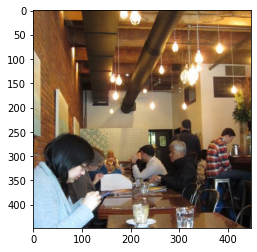

In [6]:
# Show the plain image
plt.imshow(eval_concepts[concept_id][exemplar_id].to_numpy_image())

tensor(0.) tensor(0.5358)


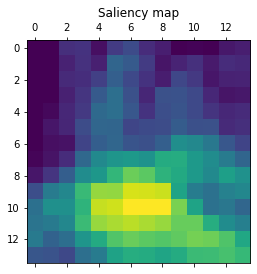

In [7]:
# Show the saliency map
plt.matshow(eval_concepts[concept_id][exemplar_id].saliency_map)
plt.title("Saliency map")
my_sal = eval_concepts[concept_id][exemplar_id].saliency_map
print(torch.min(my_sal), torch.max(my_sal))

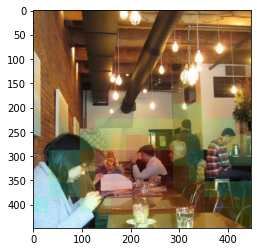

In [8]:
# Show the overlay
plt.imshow(eval_concepts[concept_id][exemplar_id].to_numpy_image_with_overlay())

In [9]:
# Show metadata
print(f"filename: {eval_concepts[concept_id][exemplar_id].path}, class_id: {eval_concepts[concept_id][exemplar_id].class_id}, image_id: {eval_concepts[concept_id][exemplar_id].image_id}")

filename: val/sushi_bar/Places365_val_00008801.jpg, class_id: 322, image_id: 32225


## Show all images for a single concept

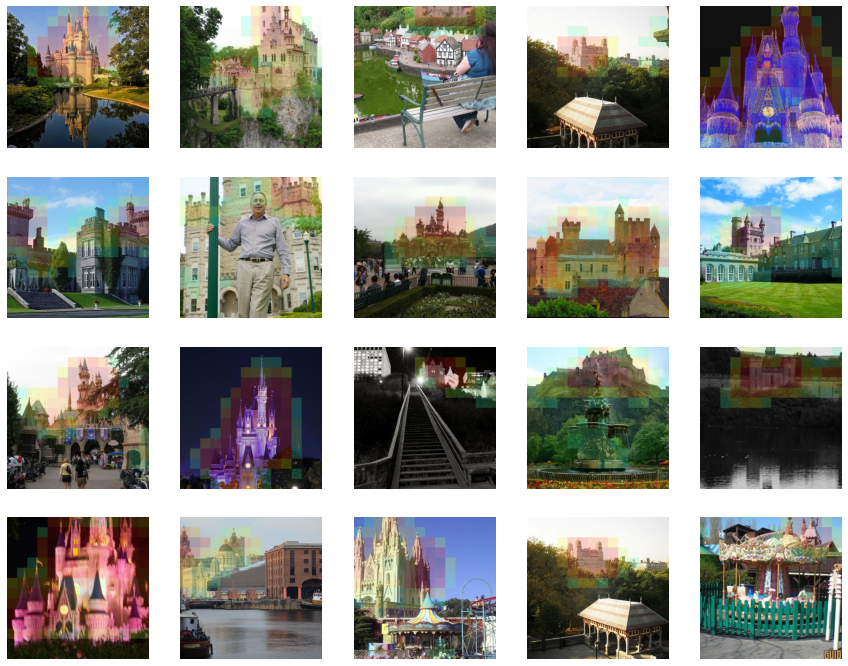

In [10]:
with_overlay = True
concept_id = 12
rows = 4
clms = 5
fig, axlist = plt.subplots(rows,clms)
for i in range(rows):
    for j in range(clms):
        if with_overlay:
            axlist[i][j].imshow(eval_concepts[concept_id][i*clms+j].to_numpy_image_with_overlay())
        else:
            axlist[i][j].imshow(eval_concepts[concept_id][i*clms+j].to_numpy_image())
        axlist[i][j].axis("off")    
fig.set_size_inches(15, 12)

# Map the concepts to their meanings with the annotation module.

This code can be used to annotate the concepts as we did for our user study. 
The results we obtained are stored in ``data/user_study/words_frcnn.json``, ``data/user_study/align_words_mse_10kwords.json``, ``data/user_study/crop_align_words_mse_10kwords.json`` for the three methods "FRCNN", "Align", "Align+Crop".

In [32]:
concept_path_prefix = "data/concepts_wo_img/"
folder_list = ["places365_Shap", "places365_kMeans", "places365_mixin5", "places365_mixin10",
               "awa_Shap", "awa_kMeans", "awa_mixin5", "awa_mixin10"]
from concept2word import *


In [33]:
# Load our dictionary.
words_dict = json.load(open("data/json/zeroshot_words.json"))
print("Loaded", len(words_dict), "words.")

annotatorOC = ObjectCentricAnnotation(topk = 5, device = "cuda:1", frcnn_labels_path="data/json/", frcnn_model_file="output/frcnn_model_final.pth") # Object-Centric

annotatorJVL = JointVisionLanguageAnnotation(word_list = words_dict, device = "cuda:1", crop = False, n_potential_words = 50)
annotatorJVLcrop = JointVisionLanguageAnnotation(word_list = words_dict, device = "cuda:1", crop = True, n_potential_words = 50) # Alignment with cropping
annotatorCLIP = JointVisionLanguageAnnotation(word_list = words_dict, device = "cuda:1", saliency_alignment=False) # Use the plain clip model
# Align
#c2w = Concept2Word(backbone = 'RN', crop = True, n_potential_words = 50, word_dict = words_dict, topk = 5, device = "cuda:0") # Align+Crop

Loaded 10037 words.
Initialized FastRCNNOutputLayerWithAttributes with 2979 attributes.
[04/06 10:20:59 d2.engine.defaults]: Modified default predictor


An example: Extract meaning for the first concept:

In [28]:
# An example:
annotators = [annotatorOC, annotatorJVL, annotatorJVLcrop, annotatorCLIP]
annotator_names = ["OC", "JVL", "JVLCrop", "CLIP (Plain)"]
for ann, ann_name in zip(annotators, annotator_names):
    print(ann_name)
    print(ann.annotate(eval_concepts[0]))

OC
[{'word': 'people', 'score': 5.326147261921429}, {'word': 'table', 'score': 3.123006709267292}, {'word': 'man', 'score': 2.4935432474560284}, {'word': 'wall', 'score': 2.169819715644339}, {'word': 'ceiling', 'score': 2.126122972034422}, {'word': 'woman', 'score': 1.3960748223314539}]
JVL


/home/dsar/miniconda3/envs/tobiasmaskrcnn/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/dsar/Documents/Tobias/solace-concepts/concept2word.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinate = numpy.array((x_lefttop, y_lefttop, x_rightlow, y_rightlow)).reshape(1, 4)


[{'word': 'dining', 'score': 21.653913497924805}, {'word': 'dinner_table', 'score': 24.239763259887695}, {'word': 'meal', 'score': 24.259159088134766}, {'word': 'eating', 'score': 25.420913696289062}, {'word': 'table', 'score': 25.514692306518555}]
JVLCrop
[{'word': 'dining', 'score': 21.454849243164062}, {'word': 'dinner_table', 'score': 24.634384155273438}, {'word': 'meal', 'score': 24.97117042541504}, {'word': 'table', 'score': 26.254724502563477}, {'word': 'restaurant', 'score': 26.436105728149414}]
CLIP (Plain)
[{'word': 'cafeteria', 'score': 1.271484375}, {'word': 'seminar', 'score': 0.841796875}, {'word': 'dining', 'score': 0.74609375}, {'word': 'conference', 'score': 0.60009765625}, {'word': 'seminars', 'score': 0.5546875}]


In [30]:
# Run to model in a loop to annotate all concepts (the words were then presented as possible option in the user study.)
overall_scores = []

for folder in folder_list:
    eval_concepts = read_concepts(concept_path_prefix + folder)
    eval_concepts = sorted(eval_concepts, key=lambda v: v.source_id, reverse=False)
    print(f"Read {len(eval_concepts)} concepts from {folder}.")
    for idx, my_concept in enumerate(eval_concepts):
        word_and_score = annotatorCLIP.annotate(my_concept)
        ret_dict = {}
        ret_dict["source_file"] = folder
        ret_dict["source_id"] = idx
        ret_dict["word_list"] = word_and_score
        print(word_and_score)
        overall_scores.append(ret_dict)
        
json.dump(overall_scores, open("output/clip_words.json", "w"))

Read 40 concepts from places365_Shap.
[{'word': 'cafeteria', 'score': 1.271484375}, {'word': 'seminar', 'score': 0.841796875}, {'word': 'dining', 'score': 0.74609375}, {'word': 'conference', 'score': 0.60009765625}, {'word': 'seminars', 'score': 0.5546875}]
[{'word': 'shopfront', 'score': 1.267578125}, {'word': 'public_house', 'score': 0.455322265625}, {'word': 'dormer', 'score': 0.425048828125}, {'word': 'awning', 'score': 0.3994140625}, {'word': 'stucco', 'score': 0.37939453125}]
[{'word': 'barn', 'score': 0.6748046875}, {'word': 'haystack', 'score': 0.53466796875}, {'word': 'outcrop', 'score': 0.2445068359375}, {'word': 'ditch', 'score': 0.2381591796875}, {'word': 'vermont', 'score': 0.2288818359375}]
[{'word': 'laundry', 'score': 4.16796875}, {'word': 'dryer', 'score': 2.212890625}, {'word': 'washer', 'score': 2.15234375}, {'word': 'appliances', 'score': 0.61767578125}, {'word': 'columns', 'score': 0.312255859375}]
[{'word': 'fire_station', 'score': 1.048828125}, {'word': 'combines